In [1]:
from kafka import KafkaConsumer
from kafka import KafkaProducer
from kafka.admin import KafkaAdminClient, NewTopic

import torch
import torch.nn as nn
import torch.optim as optim

import _thread as thread
import kafka_util
from models import CNN1D_1l_RNN as RNN
from train import forward_walk_train as train
from plotting import LiveGraph
import numpy as np
from tqdm.notebook import tqdm
from scipy import interpolate
from csaps import csaps
import datetime

In [2]:
IP = "34.107.94.158:31090"
SIGNAL = lambda t: np.sin(t/2)
SEQ_LEN = 64
FUTURE = 24
CELL = "LSTM"
HIDDEN_DIM = 32
STACK = 3
LR =  0.0005
TS_LEN = 100
INTERVAL = 300 #in ms
dev = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [3]:
"""
admin_client = KafkaAdminClient(
    bootstrap_servers=IP,
    client_id="Admin",
    api_version=(2,5,1)
)

topic_list = []
topic_list.append(NewTopic(name="statistics",
                           num_partitions=1,
                           replication_factor=1
                          ))
topic_list.append(NewTopic(name="long-term-prediction",
                          num_partitions=1,
                          replication_factor=1
                          ))

admin_client.create_topics(new_topics=topic_list, validate_only=False)
"""

'\nadmin_client = KafkaAdminClient(\n    bootstrap_servers=IP,\n    client_id="Admin",\n    api_version=(2,5,1)\n)\n\ntopic_list = []\ntopic_list.append(NewTopic(name="statistics",\n                           num_partitions=1,\n                           replication_factor=1\n                          ))\ntopic_list.append(NewTopic(name="long-term-prediction",\n                          num_partitions=1,\n                          replication_factor=1\n                          ))\n\nadmin_client.create_topics(new_topics=topic_list, validate_only=False)\n'

In [4]:
thread.start_new_thread(kafka_util.sim_traffic, (SIGNAL, IP, ))

history = torch.empty((1,1,10000),dtype=torch.float32)

model = RNN(HIDDEN_DIM,
            SEQ_LEN,
            stacked=STACK,
            future = FUTURE,
            k_size=4,
            stride=2, 
            cell_type=CELL)

optim = optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
model = model.to(dev)

In [5]:
#graph = LiveGraph()
#graph.show()

original backend: module://ipykernel.pylab.backend_inline
switch to backend: nbAgg


<IPython.core.display.Javascript object>


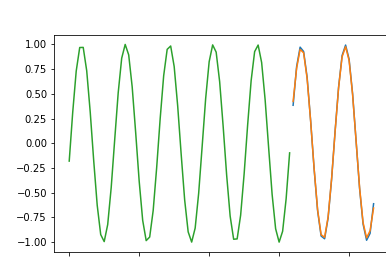

0it [00:00, ?it/s]

restore to backend: module://ipykernel.pylab.backend_inline


KeyboardInterrupt: 

In [6]:
train_dur = loss = None
with LiveGraph(backend='nbAgg') as h:
    
    line_pred = h.add_line()
    line_smooth = h.add_line()
    line_sig = h.add_line()
    
    with tqdm(enumerate(kafka_util.get_msg("statistics", IP))) as pbar:
        for i, msg in pbar:

            time = msg.value["occurredON"]
            #print(time)
            load = msg.value["kafkaMessagesPerSecond"]
            history[:,:,i] = load
            #print(f"\n{i+1} values received so far")
            if i >= SEQ_LEN + FUTURE - 1:

                bound = TS_LEN + SEQ_LEN + FUTURE -1

                if i < bound - 1:
                    ts = history[:,:,0:(i+1)].to(dev)
                else:
                    ts = history[:,:,(i+1-bound):(i+1)].to(dev)

                train_dur, loss = train(model,
                                        ts,
                                        optim,
                                        criterion,
                                        seq_len=SEQ_LEN,
                                        future=FUTURE
                                        )

                with torch.no_grad():
                    pred = model(history[:,:,(i+1-SEQ_LEN):(i+1)].to(dev))[0].cpu()
                    line_sig.update(range(SEQ_LEN), history[0,0,(i+1-SEQ_LEN):(i+1)])
                    line_pred.update(range(SEQ_LEN, SEQ_LEN+ FUTURE), pred)
                    spline_smooth = csaps(range(SEQ_LEN, SEQ_LEN+ FUTURE),
                                          pred,
                                          range(SEQ_LEN, SEQ_LEN+ FUTURE),
                                          smooth=0.8)
                    line_smooth.update(range(SEQ_LEN, SEQ_LEN+ FUTURE), spline_smooth)
                    
            #msg_out = {i:datetime.}
                    

            pbar.set_postfix(timestamp=time, train_duration=train_dur, loss=loss)
            
    
    